# Learning objective

This notebook demonstrates how to find intrinsically localized modes (discrete breathers) in highly discrete lattices.

# Preliminaries

In [1]:
# interactive plots setup
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# sympy setup
import sympy as sp
sp.init_printing()
from sympy.vector import *

# ploting customizations
from matplotlib import pyplot as plt
size=16
params = {'legend.fontsize': 'large',
#          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.875,
          'ytick.labelsize': size*0.875,
          'axes.titlepad': 25,
          'animation.embed_limit': 2**128}
plt.rcParams.update(params)
%matplotlib inline
from matplotlib import colormaps
from mpl_toolkits.mplot3d import axes3d

# for animations
from matplotlib import animation, rc
from IPython.display import HTML

# numerics
import numpy as np
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq
from scipy.interpolate import griddata
from scipy import optimize

# to save plots as files and download them
from google.colab import files

## Credit

Initial version written by [Ivan C. Christov](http://christov.tmnt-lab.org), Purdue University.

# Lattice equations of motion

Consider the lattice equations of motion (EoMs):
$$ \left. \begin{align} \dot{u}_j &= v_j,\\ \dot{v}_j &= \epsilon \left(u_{j+1} - 2u_j + u_{j-1}\right) - V'(u_j) \end{align}\right\}\quad j=0,\dots,N-1, $$
with Dirichlet boundary conditions $u_{-1}=0$ and $u_{N}=0$.

We do not solve EoMs for $j=-1$ and $j=N$, but we concatenate these points back into the solution arrary for plotting purposes.

In this context, $\epsilon = 1/h^2$ is termed the _coupling constant_.

## On-site potential

First, define the on-site potential and plot it.

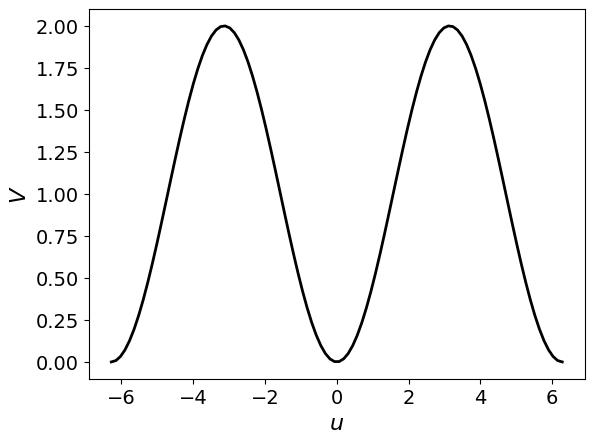

In [2]:
V, w = sp.symbols('V w')

# Frenkel-Kontorova / discrete sine-Gordon
V = 1 - sp.cos(w)
wj = np.linspace(-2*np.pi,2*np.pi,100)

# Morse
#V = (1-sp.exp(-w))**2/2
#wj = np.linspace(-1,3,100)

# lambdify V and V' for numerical evaluation
Vplot = sp.lambdify(w, V)
Vprime = sp.lambdify(w, V.diff(w))

fig, ax = plt.subplots()
ax.plot(wj, Vplot(wj), lw=2, color='black')
ax.set_ylabel('$V$')
ax.set_xlabel('$u$');

## Integration of the EoMs

Now, set up functions to handle the numerical integration of the lattice EoMs.

In [3]:
# number of lattice sites, should be "small"
N = 13
# make lattice indeces symmetric about j = 0
jj = np.linspace(-(N+1)/2,(N+1)/2,num=N+2,endpoint=True)

# coupling constant
#eps = 0.09 # Morse
eps = 0.065 # dsG

# expected period of the mode
tmax = 2*np.pi/0.7

# tolerances for the ODE integrator
tol = 1e-6

In [4]:
# ODE system right-hand side
def latticeEoMs(t,u):
  F = np.empty(2*N)

  # boundary nodes require special care
  # by definition:
  F[0]   = u[N]
  F[N-1] = u[2*N-1]
  # by Dirichlet BCs:
  F[N]     = eps*(u[1] - 2*u[0] + 0) - Vprime(u[0])
  F[2*N-1] = eps*(0 - 2*u[N-1] + u[N-2]) - Vprime(u[N-1])

  # interior nodes, per the ODE formula
  for j in range(1,N-1):
    F[j]    = u[j+N]
    F[j+N] = eps*(u[j+1] - 2*u[j] + u[j-1]) - Vprime(u[j])

  return F

## Period-$T$ map

To find an intrinsic localized mode (ILM)/discrete breather of frequency $\omega$, we must construct the period-$T$ map:
$$
  \mathbf{M} \begin{pmatrix} u_0 \\ \vdots \\ u_{N} \\ v_0 \\ \vdots \\ v_{N} \end{pmatrix} = \begin{pmatrix} u_0(T) \\ \vdots \\ u_{N}(T) \\ v_0(T) \\ \vdots \\ v_{N}(T) \end{pmatrix} - \begin{pmatrix} u_0(0) \\ \vdots \\ u_{N}(0) \\ v_0(0) \\ \vdots \\ v_{N}(0) \end{pmatrix},
$$
where $T=2\pi/\omega$.

We brute force this construction, by simply integrating the lattice EoMs to $t=T$, starting from a given initial condition vector `u0` at $t=0$.

In [5]:
def MapT(u0,T):
  sol = solve_ivp(fun=latticeEoMs,
                  t_span=[0,T], y0=u0,
                  method='DOP853', rtol=tol, dense_output=True)

  return sol.sol(T)-sol.sol(0)

For the initial guess of what the ILM should be, we try something fairly localized, like $u_j(0)=e^{-|j|^2}$ with $\dot{u}_j(0) = 0.1$. This is totally made up, but we hope it helps the iterative solver converge faster...

In [6]:
ug = np.exp(-np.abs(jj[1:N+1]**2))
guess = np.concatenate((ug,-0.7*ug))

Now, we use methods from [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/optimize.html) to attempt to find a root of the map $\mathbf{M}$.

But note that if `f_tol` is too low, the solver might have a hard time converging.

In [7]:
sol = optimize.newton_krylov(lambda u: MapT(u,tmax), guess,
                             f_tol=1e-5, verbose=True)
sol[0:N]

0:  |F(x)| = 2.26976; step 1
1:  |F(x)| = 2.13178; step 0.0378911
2:  |F(x)| = 1.85395; step 1
3:  |F(x)| = 1.80998; step 0.0246407
4:  |F(x)| = 1.76847; step 0.023768
5:  |F(x)| = 1.72895; step 0.0228265
6:  |F(x)| = 1.68994; step 0.0228683
7:  |F(x)| = 1.64739; step 0.0252967
8:  |F(x)| = 1.57543; step 0.0426955
9:  |F(x)| = 1.2938; step 0.153711
10:  |F(x)| = 0.979323; step 1
11:  |F(x)| = 0.528164; step 1
12:  |F(x)| = 0.516777; step 1
13:  |F(x)| = 0.0210276; step 1
14:  |F(x)| = 0.0207397; step 0.0129238
15:  |F(x)| = 0.0198941; step 0.0408319
16:  |F(x)| = 0.438012; step 1
17:  |F(x)| = 0.0196271; step 1
18:  |F(x)| = 0.0174668; step 1
19:  |F(x)| = 0.00242778; step 1
20:  |F(x)| = 0.000110005; step 1
21:  |F(x)| = 3.93609e-06; step 1


array([-2.98013599e-06, -2.93416615e-05, -2.85905363e-04, -2.78640613e-03,
       -2.71151232e-02, -2.65859186e-01, -2.45897042e+00, -2.65859186e-01,
       -2.71151229e-02, -2.78640651e-03, -2.85905045e-04, -2.93415134e-05,
       -2.97970915e-06])

# Results and visualization

First, obtain a new solution of the EoMs for plotting.

In [8]:
dsol = solve_ivp(fun=latticeEoMs,
                 t_span=[0,2*tmax], y0=sol,
                 method='DOP853', rtol=tol, dense_output=True)

## Static plot

Then, just a quick static plot of the solution at the final time.

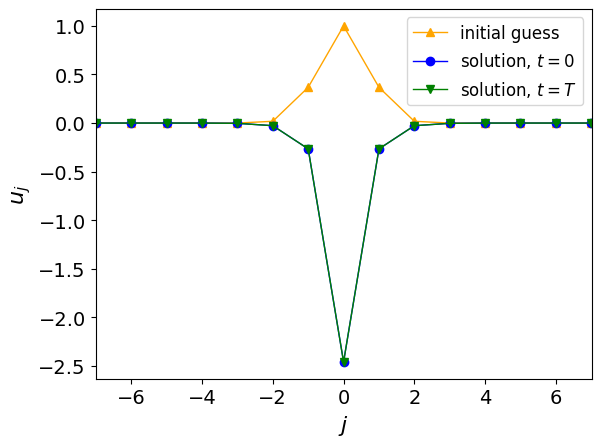

In [9]:
uj0 = np.concatenate(([0],guess[0:N],[0]))
uj = np.concatenate(([0],sol[0:N],[0]))
uj2 = np.concatenate(([0],dsol.sol(tmax)[0:N],[0]))

fig, ax = plt.subplots()
ax.plot(jj, uj0, color='orange', linewidth=1, marker='^', label='initial guess')
ax.plot(jj, uj, color='blue', linewidth=1, marker='o', label='solution, $t=0$')
ax.plot(jj, uj2, color='green', linewidth=1, marker='v', label='solution, $t=T$')

ax.set_ylabel('$u_j$')
#ax.set_ylim(-3,3)
ax.set_xlabel('$j$')
ax.set_xlim(jj[0]-0.01,jj[-1]+0.01)
#ax.set_title(f'$t=${tplot:.3f}')
ax.legend();

## Animation

Next, we visualize our results using our snazzy animation tools.

In [10]:
# define how to sample the solution in time
tnum = 100
dt = (2*tmax-0)/(tnum-1)
tspan = np.array(range(0,tnum))*dt

In [11]:
# set up the figure and axes
fig, ax = plt.subplots()
ax.set_ylabel('$u_j(t)$')
ax.set_xlabel('$j$')
ax.set_xlim(jj[0]-0.01,jj[-1]+0.01)
ax.set_ylim(-3,3)
# nice dynamic label to show time
ttl = ax.text(0.05, 0.925, '', size='large',
              #bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),
              transform=ax.transAxes, animated=True)
# so axes labels aren't cut off
plt.tight_layout()
plt.close()

# initialize plot objects with some dummy data (replaced in animation)
line, = ax.plot(jj, 0*jj, color='blue', linewidth=1, marker='o')

# animation function called sequentially by `FuncAnimation' below
def animate(it):
  uj = np.concatenate(([0],dsol.sol(it*dt)[0:N],[0]))
  line.set_data(jj, uj)
  ttl.set_text(f'$t={it*dt:.3f}$')

  return (line, ttl, )

framran = range(0,tnum)
anim = animation.FuncAnimation(fig, animate, frames=framran,
                               interval=100, blit=True)

# this is necessary to get the animation to work on Google's Colab
rc('animation', html='jshtml')
anim

Output hidden; open in https://colab.research.google.com to view.

## Space-time plot

Finally, we make a static space-time plot.

In [12]:
# define how to sample the solution in time
tnum = 100
dt = (2*tmax-0)/(tnum-1)
tspan = np.array(range(0,tnum))*dt

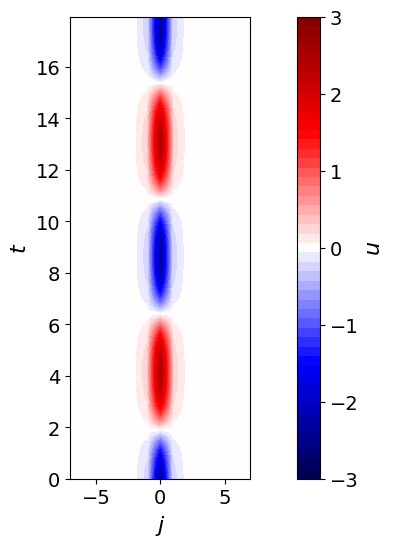

In [13]:
# make a matrix of space-time values u(x,t)
ujp = np.empty((tnum,N+2))
for it in range(0,tnum):
  ujp[it,:] = np.concatenate(([0],dsol.sol(it*dt)[0:N],[0]))

fig, ax = plt.subplots(figsize=(12, 6))

# best to use a diverging colormap
# but also cmap='RdGy' or 'twilight_shifted' for a cool effect
levels =  np.linspace(-np.ceil(ujp.max()), np.ceil(ujp.max()), 50)
plt.contourf(jj, tspan, ujp, levels, cmap='seismic')

cbar = plt.colorbar(label='$u$')
cbar.set_ticks(ticks=[-3, -2, -1, 0, 1, 2, 3])

#ax.set_ylim(0,2*tmax)
ax.set_ylabel('$t$')
ax.set_xlim(jj[0]-0.01,jj[-1]+0.01)
ax.set_xlabel('$j$')
ax.set_aspect(2/1)

# Conservation properties of the solution

The energy ("Hamiltonian") should be  conserved,
$$ \sum_j \left\{\tfrac{1}{2}[v_j(t)]^2 + W\big(u_{j+1}(t)-u_j(t)\big) + V\big(u_j(t)\big) \right\}\approx const. \quad\text{for all $t>0$}, $$
where recall that $W(u) = \tfrac{1}{2}\epsilon u^2$.


In [29]:
# define how to sample the solution in time
tnum = 500
dt = (tmax-0)/(tnum-1)
tspan = np.array(range(0,tnum))*dt

In [30]:
# compute the momentum and energy as functions of t
# but only at the interior nodes
#momentum = np.empty(tnum)
energy = np.empty(tnum)
for it in range(0,tnum):
  uj = dsol.sol(it*dt)[0:N]
  vj = dsol.sol(it*dt)[N:2*N]
  uxj = uj[1:N] - uj[0:N-1]
  # apply BC for j=N-1
  uxj = np.concatenate((uxj,[(uj[N-1]-0)]))

  #momentum[it] = sum(vj*uxj)
  energy[it] = sum(0.5*vj**2 + 0.5*eps*uxj**2 + Vplot(uj))

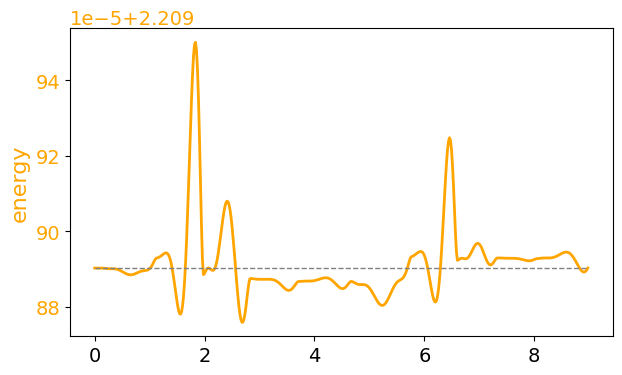

In [31]:
fig, ax1 = plt.subplots(figsize=(7,4))

# energy on the left axis
ax1.plot(tspan, energy, color='orange', lw=2)
ax1.plot(tspan, energy[0]*np.ones_like(tspan), color='gray', lw=1, ls='--')
ax1.set_ylabel('energy', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

# # momentum on the right axis
# ax2 = ax1.twinx()
# ax2.plot(tspan, momentum, lw=2, color='purple')
# ax2.set_ylabel('pseudomomentum', color='purple')
# ax2.set_xlabel('$t$')
# ax2.tick_params(axis='y', labelcolor='purple')

# Ideas to explore on your own

A few ideas for interesting "computational experiments" to explore on your own are outlined here.

1.   Consider the other two example onsite potential from [Mar&iacute;n &amp; Aubry](https://iopscience-iop-org.ezproxy.lib.purdue.edu/article/10.1088/0951-7715/9/6/007/pdf), namely

  a.   the Lennard&ndash;Jones potential, $V_{\mathrm{LJ}}(u) = \frac{1}{72}\left(\frac{1}{u^{12}} - \frac{2}{u^6} \right)$,

  b.   and the "simple cubic" potential, $V_\mathrm{c}(u) = \frac{1}{2}u^2 - \frac{1}{3}u^3$.

2.   For the sine-Gordon lattice, attempt to produce the "bond-centered" and "multibreather" solutions discussed in Fig. 7 of [M. Chirilus-Bruckner _et al._](https://arxiv.org/abs/1403.6271).



